In [ ]:
!pip install pandas matplotlib seaborn tensorflow numpy

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Bidirectional, Dense, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

import numpy as np

In [2]:
names = ['']

In [3]:
data = pd.read_csv('train.csv')

In [4]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [5]:
# Extract all headers for visualization except text, comment_id and video_id
column_headers = data.columns.tolist()[2:]
print(column_headers)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [6]:
# Total of occurence of each labels
label_counts = data[column_headers].sum().sort_values()
print(label_counts)

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64


Text(0.5, 1.0, 'Distribution of Labels Occurence')

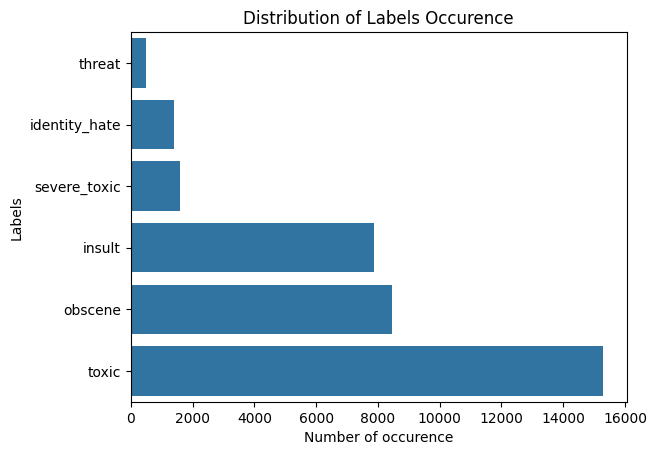

In [7]:
# Visualize the class distribution of the label column
ax = sns.barplot(x=label_counts.values,
                y=label_counts.index)

# Adding labels and title for the visualization
plt.xlabel('Number of occurence')
plt.ylabel('Labels')
plt.title('Distribution of Labels Occurence')

In [8]:
# Show the plot
plt.show()

In [9]:
# Create subsets of clean and toxic comments
toxic_comments = data[data[column_headers].sum(axis=1) > 0]
clean_comments = data[data[column_headers].sum(axis=1) == 0]

In [10]:
num_toxic_comments = len(toxic_comments)
num_clean_comments = len(clean_comments)

In [11]:
# Create DataFrame for visualization
plot_data = pd.DataFrame({
    'Category': ['Toxic', 'Clean'],
    'Count': [num_toxic_comments, num_clean_comments]
})

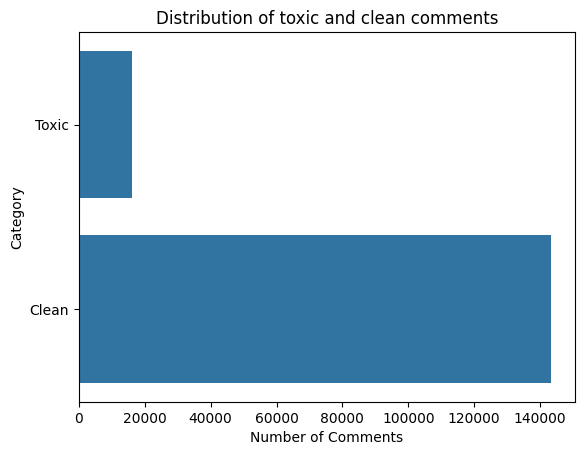

In [12]:
ax = sns.barplot(x='Count',y='Category', data=plot_data)

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of toxic and clean comments')

plt.show()

In [13]:
# Handle dataset imbalance
train_clean_sample = clean_comments.sample(16225, random_state=42)
# Combine into one dataset
df = pd.concat([train_clean_sample, toxic_comments])
#Shuffle to avoid order bias
df = df.sample(frac=1, random_state=42)

In [14]:
comments = df['comment_text']

In [15]:
labels = df[df.columns[2:]]
labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
43242,0,0,0,0,0,0
44937,1,0,0,0,0,0
151831,0,0,0,0,0,0
128030,0,0,0,0,0,0
61287,0,0,0,0,0,0
...,...,...,...,...,...,...
133109,1,1,1,1,1,0
27165,0,0,0,0,0,0
97660,0,0,0,0,0,0
78629,0,0,0,0,0,0


In [16]:
MAX_WORDS = 200000

In [17]:
# INITILIZATION VECTORIZER TO ENCODE COMMENTS INTO INT
vectorizer = TextVectorization(max_tokens=MAX_WORDS, 
                           output_sequence_length=1800,
                           output_mode='int')

In [18]:
# Encode text into int using vectorizer
vectorizer.adapt(comments.values)
vectorized_text = vectorizer(comments.values)

In [19]:
vectorized_text

<tf.Tensor: shape=(32450, 1800), dtype=int64, numpy=
array([[   70,   101,     4, ...,     0,     0,     0],
       [   51,  1569, 11339, ...,     0,     0,     0],
       [  333,     6,    57, ...,     0,     0,     0],
       ...,
       [  325,   359,     7, ...,     0,     0,     0],
       [  813,    36,   520, ...,     0,     0,     0],
       [    5,  1403,   939, ...,     0,     0,     0]])>

In [20]:
# Build data pipeline for model
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, labels))
dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

In [21]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [22]:
# Split data into train set, test set, validation set
train = dataset.take(int(len(dataset) * .7))
val = dataset.skip(int(len(dataset) * .7)).take(int(len(dataset) * .2))
test = dataset.skip(int(len(dataset) * .9)).take(int(len(dataset) * .1))

In [23]:
model = Sequential()
# Create embedding layer 
model.add(Embedding(MAX_WORDS+1, 32))
# Birectional LSTM later
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
# Final layer map to different output 
model.add(Dense(6, activation='sigmoid'))

In [24]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [26]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
709/710 [============================>.] - ETA: 0s - loss: 0.2590 - accuracy: 0.9531

2024-01-16 14:44:56.633601: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 188s 264ms/step - loss: 0.2590 - accuracy: 0.9532 - val_loss: 0.1920 - val_accuracy: 0.9708
Epoch 2/10


2024-01-16 14:45:06.022073: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1778 - accuracy: 0.9484

2024-01-16 14:48:05.370679: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 189s 266ms/step - loss: 0.1778 - accuracy: 0.9484 - val_loss: 0.1835 - val_accuracy: 0.9692
Epoch 3/10


2024-01-16 14:48:14.523935: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.8866

2024-01-16 14:51:12.465855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 187s 263ms/step - loss: 0.1492 - accuracy: 0.8867 - val_loss: 0.1850 - val_accuracy: 0.9600
Epoch 4/10


2024-01-16 14:51:21.481356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1296 - accuracy: 0.8463

2024-01-16 14:54:18.886272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 186s 263ms/step - loss: 0.1296 - accuracy: 0.8459 - val_loss: 0.2054 - val_accuracy: 0.6369
Epoch 5/10


2024-01-16 14:54:27.899419: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1135 - accuracy: 0.7795

2024-01-16 14:57:25.082419: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 186s 262ms/step - loss: 0.1135 - accuracy: 0.7798 - val_loss: 0.1986 - val_accuracy: 0.9615
Epoch 6/10


2024-01-16 14:57:34.043616: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.7547

2024-01-16 15:05:42.396527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 497s 701ms/step - loss: 0.0987 - accuracy: 0.7546 - val_loss: 0.2030 - val_accuracy: 0.7685
Epoch 7/10


2024-01-16 15:05:51.306388: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0870 - accuracy: 0.6731

2024-01-16 15:08:47.516355: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 185s 261ms/step - loss: 0.0871 - accuracy: 0.6729 - val_loss: 0.2290 - val_accuracy: 0.7091
Epoch 8/10


2024-01-16 15:08:56.452246: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.6992

2024-01-16 15:11:53.292474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 186s 262ms/step - loss: 0.0757 - accuracy: 0.6990 - val_loss: 0.2372 - val_accuracy: 0.7377
Epoch 9/10


2024-01-16 15:12:02.265955: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0669 - accuracy: 0.7573

2024-01-16 15:14:59.341020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 186s 262ms/step - loss: 0.0671 - accuracy: 0.7570 - val_loss: 0.2486 - val_accuracy: 0.8347
Epoch 10/10


2024-01-16 15:15:08.310004: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.7836

2024-01-16 15:18:06.564900: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 187s 264ms/step - loss: 0.0599 - accuracy: 0.7836 - val_loss: 0.2650 - val_accuracy: 0.8404


2024-01-16 15:18:15.525890: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [27]:
history.history

{'loss': [0.25897738337516785,
  0.1777588129043579,
  0.14924049377441406,
  0.12964823842048645,
  0.1135200634598732,
  0.09871596097946167,
  0.08706682175397873,
  0.07573820650577545,
  0.06709076464176178,
  0.05993341654539108],
 'accuracy': [0.9531689882278442,
  0.9483714699745178,
  0.8866637349128723,
  0.845906674861908,
  0.7797975540161133,
  0.7546215057373047,
  0.6728873252868652,
  0.6989876627922058,
  0.7569542527198792,
  0.7836267352104187],
 'val_loss': [0.19204482436180115,
  0.18348656594753265,
  0.185048446059227,
  0.20541098713874817,
  0.19862006604671478,
  0.20295441150665283,
  0.2290208786725998,
  0.23720800876617432,
  0.24858281016349792,
  0.2650442123413086],
 'val_accuracy': [0.9707512259483337,
  0.9692118167877197,
  0.9599753618240356,
  0.6368534564971924,
  0.9615147709846497,
  0.7684729099273682,
  0.7090517282485962,
  0.7376847267150879,
  0.8346675038337708,
  0.8403633236885071]}

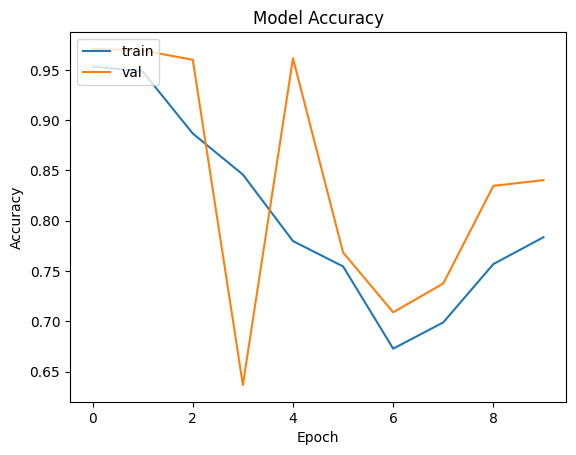

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

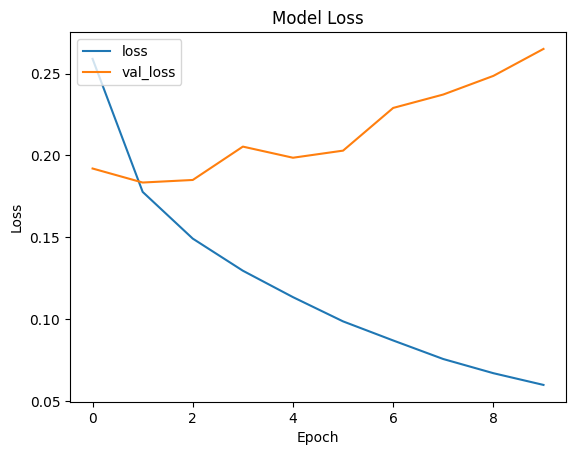

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [30]:
res = model.predict(np.expand_dims(input_text,0))

NameError: name 'input_text' is not defined

In [ ]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_x) > .5).astype(int)

In [ ]:
def make_prediction(input_text):
    vectorized_text = vectorizer(input_text)
    return (model.predict(np.expand_dims(vectorized_text,0)) > 0.5).astype(int)

In [ ]:
batch_y

In [ ]:
make_prediction('you are suck')

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # getting value x, y from batch
    x_true, y_true = batch

    # Making prediction from x_true
    predicted_y = model.predict(x_true)

    # Flatten prediction
    y_true = y_true.flatten()
    predicted_y = predicted_y.flatten()

    pre.update_state(y_true, predicted_y)
    re.update_state(y_true, predicted_y)
    acc.update_state(y_true, predicted_y)

In [ ]:
print(f'Precision: {pre.result()}, Accuracy: {acc.result()}, Recall: {re.result()}')

In [ ]:
!pip install gradio jinja2

In [ ]:
model.save('toxicity.keras')